# 모델 정의

In [2]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


In [3]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


In [4]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

✅


In [5]:
import tensorflow as tf
import os

model_file = './srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [6]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

# train, valid = tfds.load(
#     "div2k/bicubic_x4", 
#     split=["train","validation"],
#     as_supervised=True
# )

# for i, (lr, hr) in enumerate(valid):
#     if i == 6: break

# srgan_hr = apply_srgan(lr)
print("✅")

✅


In [24]:
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

In [12]:
import cv2
import matplotlib.pyplot as plt

img_ori = cv2.imread('./zoa.jpg',1)
img_ori = cv2.cvtColor(img_ori,cv2.COLOR_BGR2RGB)
img_resize = cv2.resize(img_ori,dsize=(0,0),fx=0.25,fy=0.25,interpolation=cv2.INTER_CUBIC)
bicubic_hr = cv2.resize(img_resize,dsize=(0,0),fx=4,fy=4,interpolation=cv2.INTER_CUBIC)

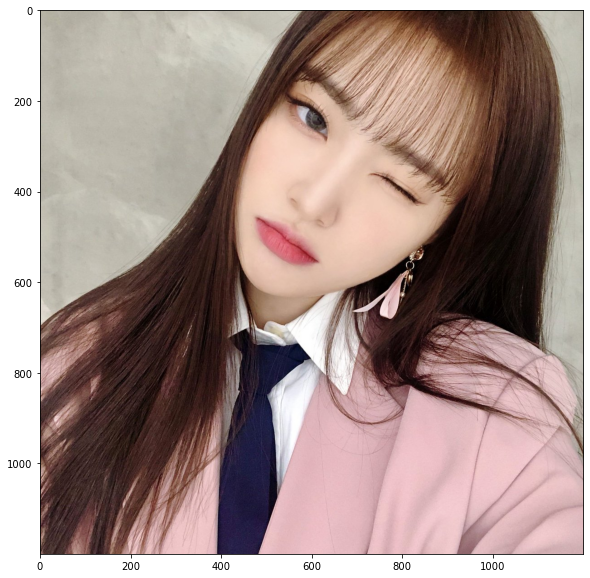

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(img_ori)

In [19]:
srgan_hr = apply_srgan(img_resize)

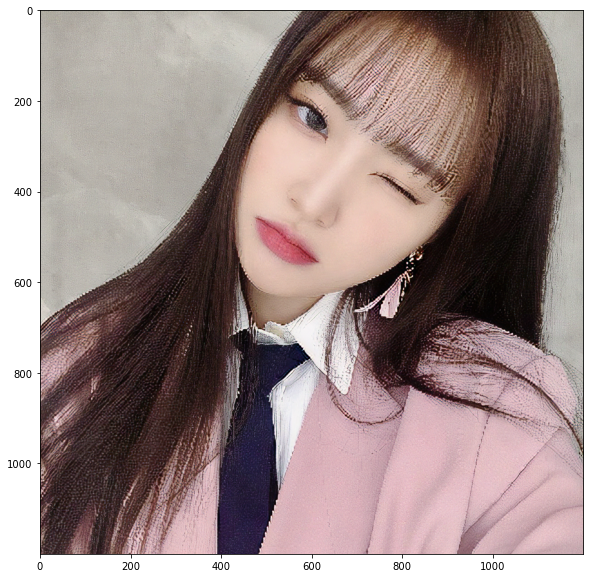

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(srgan_hr)

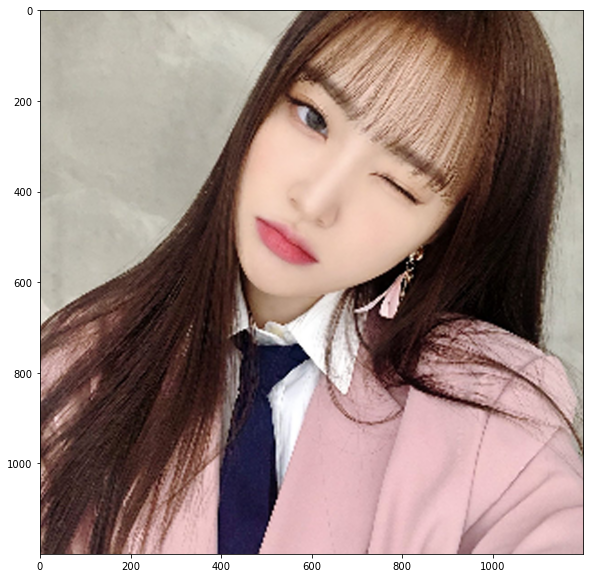

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(bicubic_hr)

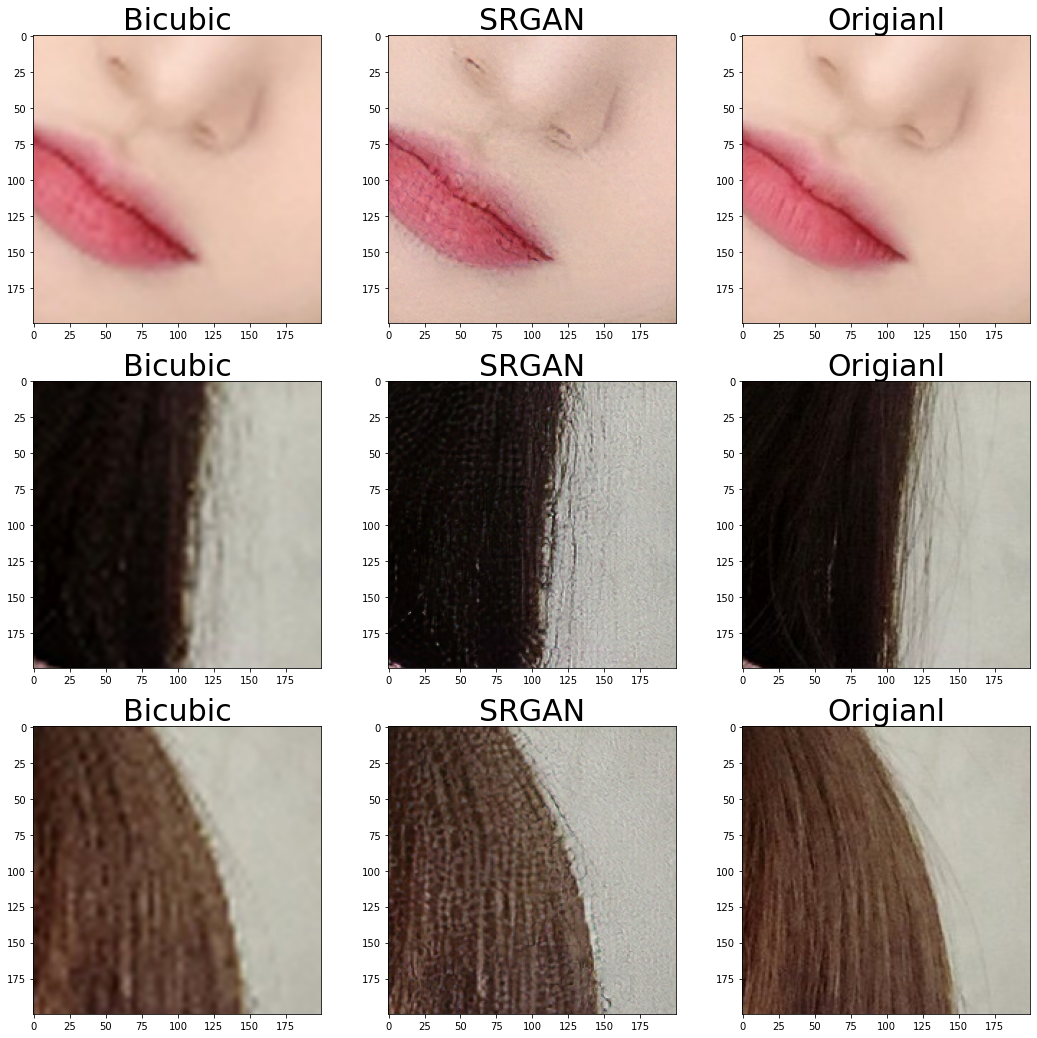

In [25]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (500,1000), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(img_ori, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "Origianl"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

# 결과
- bicubic의 결과는 대체로 blur 처럼 뿌옇게 변하는 현상이 있다.
- SRGAN으로 해상도를 높인 결과는 색이 변하는 경계선 부분에서 다소 랜덤한 값으로 되는것을 볼 수 있었다.
- 머리카락같은 곳에서는 거칠게 변한다.


In [37]:
img_ori = cv2.imread('./zoa2.jpeg',1)
img_ori = cv2.cvtColor(img_ori,cv2.COLOR_BGR2RGB)
# img_resize = cv2.resize(img_ori,dsize=(0,0),fx=0.25,fy=0.25,interpolation=cv2.INTER_CUBIC)
bicubic_hr = cv2.resize(img_ori,dsize=(0,0),fx=4,fy=4,interpolation=cv2.INTER_CUBIC)

In [38]:
srgan_hr = apply_srgan(img_ori)

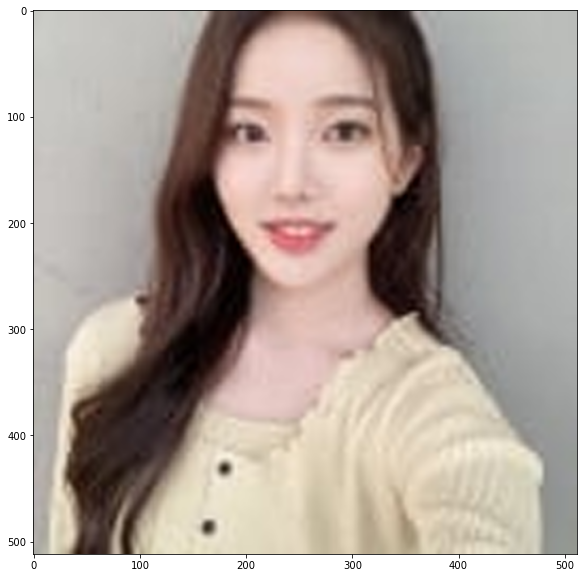

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(bicubic_hr)

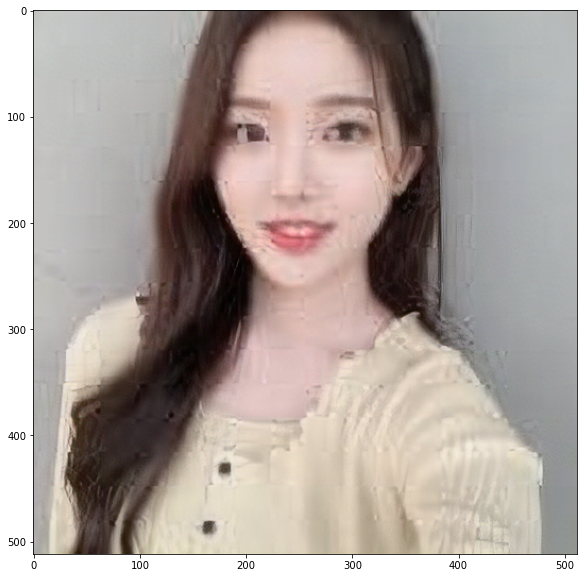

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(srgan_hr)

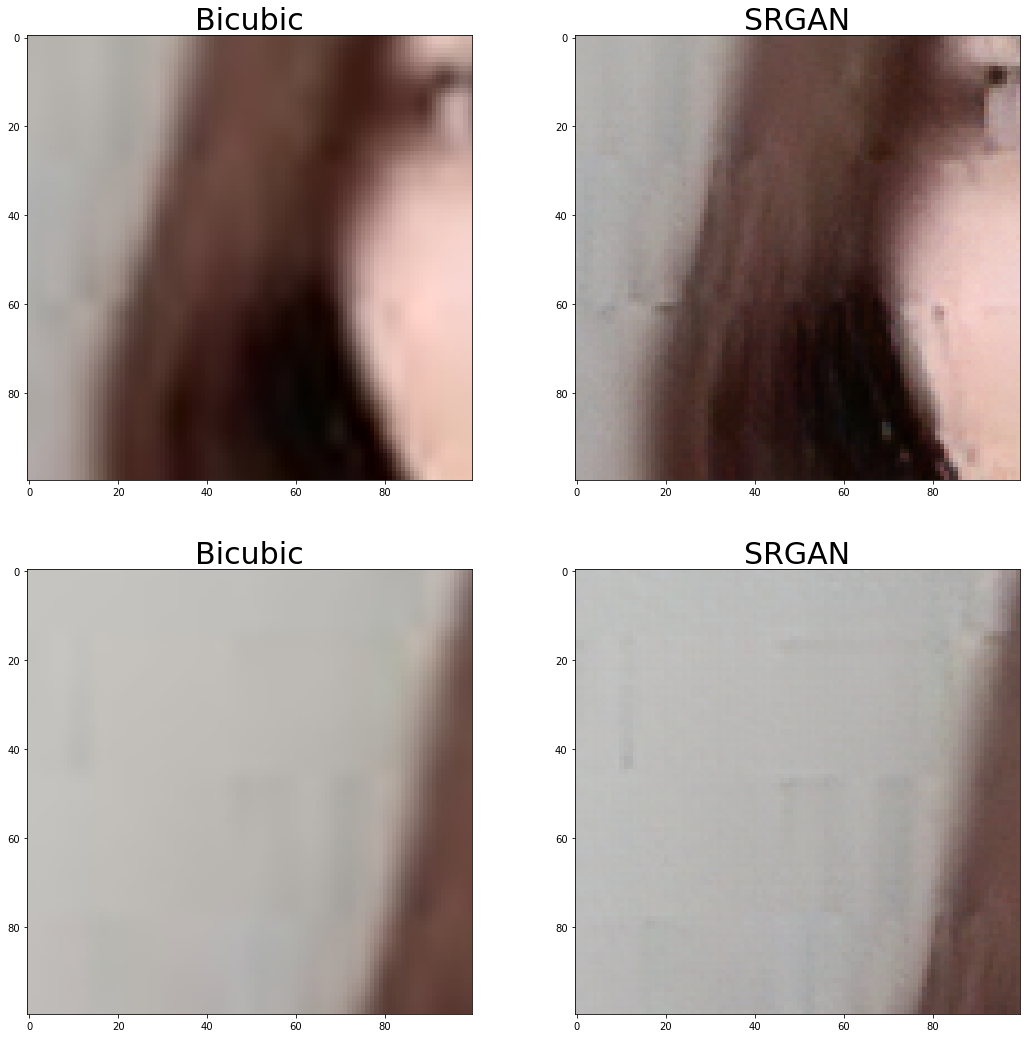

In [43]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(100,100), (50,50), (300,350)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 100, 100)
    img2 = crop(srgan_hr , left_top, 100, 100)    
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(4):
    plt.subplot(2,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

# 결과 확인
- 작은 이미지를 키우다 보니 많은 픽셀 정보를 담지 못해서 bicubic, srgan모두 제대로 해상도가 올라가지는 않았다.
- 작은 

In [45]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("zoa111.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 13
frame 크기 : (128, 128, 3)


In [46]:
frames_sr = []
for i in range(len(frames)):
    frames_sr.append(apply_srgan(frames[i]))

In [47]:
import imageio

imageio.mimsave("고해상도.gif", frames_sr)

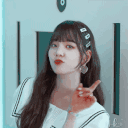

In [50]:
from IPython.display import Image as show_gif

show_gif("zoa111.gif", width=500) # width 는 적당히 큰 값으로 설정해주세요

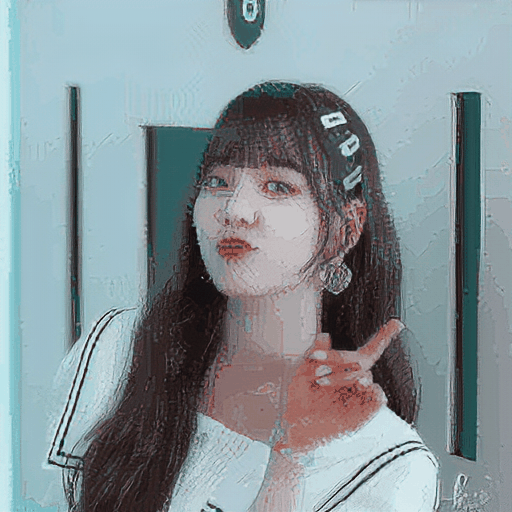

In [51]:
show_gif("고해상도.gif", width=500) # 위에서 설정한 width와 같은 값으로 설정해주세요